### Import libraries

In [1]:
from model import model, losses, dot_prod_attention
from data import data_generation, batch_creator, gp_kernels
from keras.callbacks import ModelCheckpoint
from helpers import helpers, masks
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(50000, gp_kernels.rbf_kernel)

In [4]:
pp = masks.position_mask(pad_pos_tr)
pp_te = masks.position_mask(pad_pos_te)

In [16]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [17]:
@tf.function
def train_step(pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = masks.create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
#         print('pred: ')
#         tf.print(pred)

        loss = losses.loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)
#     tf.print(gradients)
# Ask the optimizer to apply the processed gradients.
    optimizer_c.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
#     b = decoder.trainable_weights[0]
#     tf.print(tf.reduce_mean(b))

In [18]:
@tf.function
def test_step(pos_te, tar_te, pos_mask_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask_te (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_tar_te = masks.create_masks(tar_inp_te)
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    pred = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    t_loss = losses.loss_function(tar_real_te, pred)
    test_loss(t_loss)

In [19]:
tf.keras.backend.set_floatx('float64')

In [20]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam()
    decoder = model.Decoder(16)
    EPOCHS = 50
    batch_s  = 128
    run = 0; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    tf.random.set_seed(1)    
    checkpoint = tf.train.Checkpoint(optimizer = optimizer_c, model = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)

    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()

            for batch_n in range(num_batches):
                batch_pos_tr, batch_tar_tr, batch_pos_mask, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, pp)
                # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
                # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
                train_step(batch_pos_tr, batch_tar_tr, batch_pos_mask)

                if batch % 50 == 0:
                    batch_pos_te, batch_tar_te, batch_pos_mask_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te, pp_te)
                    test_step(batch_pos_te, batch_tar_te, batch_pos_mask_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result())
                    checkpoint.save(folder + '/')
                step += 1

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Epoch 0 batch 0 train Loss 0.0108 test Loss 0.2201
Epoch 0 batch 1 train Loss 0.1044 test Loss 0.1249
Epoch 0 batch 2 train Loss 0.0800 test Loss 0.0943
Epoch 0 batch 3 train Loss 0.0669 test Loss 0.1000
Epoch 0 batch 4 train Loss 0.0763 test Loss 0.1000
Epoch 0 batch 5 train Loss 0.0794 test Loss 0.0875
Epoch 0 batch 6 train Loss 0.0715 test Loss 0.0771


KeyboardInterrupt: 

In [30]:
pos = df_te[560, :].reshape(1, -1)

In [31]:
tar = df_te[561, :39].reshape(1, -1)

In [36]:
df_te[561, :]

array([0.79421483, 0.82273214, 0.78303935, 0.78081123, 0.84008443,
       0.93063795, 0.75938485, 0.78951207, 0.85226032, 0.82714972,
       0.83747097, 0.82860228, 0.81902547, 0.83490666, 0.8305321 ,
       0.83953733, 0.78421542, 0.82523238, 0.81893981, 0.7845124 ,
       0.79444966, 0.82777025, 0.8737039 , 0.84331259, 0.77790632,
       0.72681742, 0.83917158, 0.8450379 , 0.87636089, 0.89078672,
       0.83436773, 0.81889668, 0.82095995, 0.8350107 , 0.75424744,
       0.87638343, 0.8746333 , 0.78314555, 0.77521238, 0.83750439,
       0.88058447, 0.81881745, 0.91279156, 0.78103321, 0.82639293,
       0.7769952 , 0.81967033, 0.82250717, 0.84540936, 0.74881181,
       0.84004019, 0.79126806, 0.81754296, 0.86202801, 0.80911221,
       0.87486705, 0.71336508, 0.8125778 , 0.76446845])

In [32]:
def evaluate(pos, tar, pos_mask):
    '''
    
    '''
    combined_mask_tar = create_masks(tar)
    out = decoder(pos, tar, False, pos_mask, combined_mask_tar)
    return out

In [33]:
def inference(pos, tar, num_steps = 1):
    '''
    
    ------------------
    Parameters:
    pos (2D np array): (n + num_steps) positions 
    tar (2D np array): n targets 
    num_steps (int): how many inference steps are required
    ------------------
    Returns:
    out (tf.tensor float64): the predictions for all timestamps up to n + num_steps  
    
    '''
    n = tar.shape[1]
    temp_pos = pos[:, :(n + 1)]
    pos_mask = position_mask(temp_pos)
    
    out = evaluate(temp_pos, tar, pos_mask)
#     print(out[n - 1])
    tar = tf.concat((tar, tf.reshape(out[n - 1], [1, 1])), axis = 1)
    if num_steps > 1:
        out = inference(pos, tar, num_steps - 1)
    
    return out
    

In [34]:
a = inference(pos, tar, 20)

tf.Tensor(0.8241398577782234, shape=(), dtype=float64)
tf.Tensor(0.8241979832058564, shape=(), dtype=float64)
tf.Tensor(0.8242541256248841, shape=(), dtype=float64)
tf.Tensor(0.8243043343657172, shape=(), dtype=float64)
tf.Tensor(0.8243582809798264, shape=(), dtype=float64)
tf.Tensor(0.8243396267129595, shape=(), dtype=float64)
tf.Tensor(0.8243726973824703, shape=(), dtype=float64)
tf.Tensor(0.8234560203767337, shape=(), dtype=float64)
tf.Tensor(0.8234830424281215, shape=(), dtype=float64)
tf.Tensor(0.8235090683135358, shape=(), dtype=float64)
tf.Tensor(0.8235348383079335, shape=(), dtype=float64)
tf.Tensor(0.8237256968841214, shape=(), dtype=float64)
tf.Tensor(0.823977861619993, shape=(), dtype=float64)
tf.Tensor(0.8240096644136029, shape=(), dtype=float64)
tf.Tensor(0.8241489526617438, shape=(), dtype=float64)
tf.Tensor(0.824299003452675, shape=(), dtype=float64)
tf.Tensor(0.8243331891052343, shape=(), dtype=float64)
tf.Tensor(0.8243667639624348, shape=(), dtype=float64)
tf.Tensor(0.

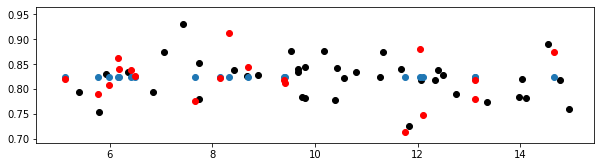

In [37]:
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.scatter(pos[:, :39], tar[:, :39], c='black')
    plt.scatter(pos[:, 39:58], a[39:])
    plt.scatter(pos[:, 39:58], df_te[561, 39:58], c='red')

In [ ]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))